In [155]:
import torch
from torch.optim import SGD, Adam
from torch import nn
import torch
from typing import List
from torchvision.datasets import MNIST
from torchvision import transforms as tv
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from time import sleep
from torchvision.models import vgg16, vgg16_bn, resnet50, resnet18
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter
from typing import Tuple
import torchvision.datasets as dset
import torchvision.transforms as transforms
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [157]:
ds_train = MNIST(root="data", train=True, download=True, transform=transforms.Compose(
        [transforms.Resize(64), transforms.ToTensor()]
    ))

ds_test = MNIST(root="data", train=False, download=True, transform=transforms.Compose(
       [transforms.Resize(64), transforms.ToTensor()]
    ))

In [158]:
batch_size=128
dl_train = DataLoader(ds_train, batch_size, shuffle=True, drop_last=True) # dataloader with full dataset 

dl_test = DataLoader(ds_test, batch_size, shuffle=False)

In [159]:
#linear
class Generator(nn.Module):
  def __init__(self, noise_dim, img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(noise_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.1),
        nn.Linear(512, img_dim),
        nn.Tanh(),
    )
    

  def forward(self, x):
    return self.gen(x)
   
class Discriminator(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(input_features, 128), #28*28*1?
            nn.LeakyReLU(0.1),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, images):
        return self.disc(images)



In [160]:
def train_uncon(gen: Generator, disc: Discriminator, train_loader, num_epochs: int):
  gen.train()
  disc.train()
  for e in range(num_epochs):
    counter = 0
    print(e, "eeeeeeee")
    for (real_images, _) in dl_train:
      counter += 1
      real = real_images.view(-1, 64*64).to(device)
      noise = torch.randn(batch_size, noise_dim).to(device)
      fake = gen(noise)
      disc_real = disc(real).view(-1)
      lossD_real = loss(disc_real, torch.ones_like(disc_real))
      disc_fake = disc(fake.detach()).view(-1)
      lossD_fake = loss(disc_fake, torch.zeros_like(disc_fake))
      lossD= (lossD_real + lossD_fake) / 2
      disc.zero_grad()
      lossD.backward(retain_graph=True)
      opt_disc.step()
      
      output = disc(fake).view(-1)
      lossG = loss(output, torch.ones_like(output))
      gen.zero_grad()
      lossG.backward()
      opt_gen.step()
    
      if counter%20 == 0:
        num_row = 2
        num_col = 10
        fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
        for i in range(20):
          ax = axes[i//num_col, i%num_col]
          if i//num_col == 0:
            ax.imshow(fake[i].detach().cpu().numpy().reshape(64,64), cmap='gray')
          else:
            ax.imshow(real_images[i%num_col].reshape(64,64), cmap='gray')

        plt.tight_layout()
        plt.show()

In [161]:
noise_dim = 100 #128, 256
img_dim = 64*64*1

lr = 3e-4

genlin = Generator(noise_dim, img_dim).to(device)
disclin = Discriminator(img_dim).to(device)

#initialize_weights(genlin)
#initialize_weights(disclin)

opt_gen = Adam(genlin.parameters(), lr=lr)
opt_disc = Adam(disclin.parameters(), lr=lr)

loss = nn.BCELoss()

In [162]:
#train_uncon(genlin, disclin, train_loader=dl_train, num_epochs=6)

In [163]:
#convolutional

class Generator(nn.Module):
  def __init__(self, noise_dim, img_channels, input_features_g):
    """
    noise_dim - size of the noise vector
    
    """
    super().__init__()

    self.gen = nn.Sequential(
        self._block(noise_dim, input_features_g*16, 4, 1, 0),
        self._block(input_features_g*16, input_features_g*8, 4, 2, 1),
        self._block(input_features_g*8, input_features_g*4, 4, 2, 1),
        self._block(input_features_g*4, input_features_g*2, 4, 2, 1),
        nn.ConvTranspose2d(input_features_g*2, img_channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
    )
    
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
          return nn.Sequential(
              nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(),
          )   

  def forward(self, x):
    return self.gen(x)
    


class Discriminator(nn.Module):
    def __init__(self, img_channels, input_features_d):
        super().__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, input_features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(input_features_d, input_features_d*2, 4, 2, 1),
            self._block(input_features_d*2, input_features_d*4, 4, 2, 1),
            self._block(input_features_d*4, input_features_d*8, 4, 2, 1),
            nn.Conv2d(input_features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
          return nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
              nn.BatchNorm2d(out_channels),
              nn.LeakyReLU(0.2),
          )
          
    def forward(self, images):
        return self.disc(images)

def initialize_weights(model):#weights initialization
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)


                         

In [164]:
noise_dim = 100 #64, 128, 256
img_dim = 64*64*1

input_features_g = 64
input_features_d = 64
img_channels = 1

lr = 3e-4

gen_conv = Generator(noise_dim, img_channels, input_features_g).to(device)
disc_conv = Discriminator(img_channels, input_features_d).to(device)

#initialize_weights(gen_conv)
#initialize_weights(disc)cinv)

opt_gen = Adam(gen_conv.parameters(), lr=lr, betas=(0.5, 0.999))#like in DCGAN paper
opt_disc = Adam(disc_conv.parameters(), lr=lr, betas=(0.5, 0.999))

loss = nn.BCELoss()

In [165]:
#train_uncon(gen_conv, disc_conv, train_loader=dl_train, num_epochs=10)


## How is this related to conditional models?

When traininng a classical GAN, we sample the noise vectors from a distribution of our choice and have little control over what we'll generate. To help with that, we can add inject a **condition** e.g. the class of our sample, to the model.

It is quite simple to achieve this. Discriminator and generator should have additional modules which process the condition (e.g. in the form of one-hot vector) into a vector of desired shape and concatenate this vector with the model input:
* for $G$, concatenate label output with noise vector
* for $D$, concatenate label output with the classified image (e.g. as an additional channel)

## Task for you - implement a cGAN
* implement two variants of generators / discriminators
  * built with linear layers (+ activations, batchnorm, dropout, etc)
  * built with convolutional layers  (+ activations, batchnorm, dropout, etc), except the final linear layer of the discriminator

You can use the code below as a start:


In [166]:
#convolutional

class CGenerator(nn.Module):
  def __init__(self, noise_dim, img_channels, input_features_g, num_classes, img_size, embed_size):
    """
    noise_dim - size of the noise vector
    
    """
    super().__init__()
    self.img_size = img_size
    self.gen = nn.Sequential(
        self._block(noise_dim+embed_size, input_features_g*16, 4, 1, 0),
        self._block(input_features_g*16, input_features_g*8, 4, 2, 1),
        self._block(input_features_g*8, input_features_g*4, 4, 2, 1),
        self._block(input_features_g*4, input_features_g*2, 4, 2, 1),
        nn.ConvTranspose2d(input_features_g*2, img_channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
    )
    self.embed = nn.Embedding(num_classes, embed_size)

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
          return nn.Sequential(
              nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(),
          )   

  def forward(self, x, labels):
    embedding = self.embed(labels)[:x.shape[0]].unsqueeze(2).unsqueeze(3)
    x = torch.cat([x, embedding], dim=1)
    return self.gen(x)


class CDiscriminator(nn.Module):
    def __init__(self, img_channels, input_features_d, num_classes, img_size):
        super().__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels+1, input_features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(input_features_d, input_features_d*2, 4, 2, 1),
            nn.Conv2d(input_features_d*2, 1, kernel_size=7, stride=2, padding=0),
            nn.Sigmoid()
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
          return nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
              nn.BatchNorm2d(out_channels),
              nn.LeakyReLU(0.2),
          )
          
    def forward(self, x, labels):
        embedding = self.embed(labels).view(x.shape[0], 1 ,self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x)

def initialize_weights(model):#weights initialization
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)


                         
        

In [167]:
input_features_g = 64
input_features_d = 64

noise_dim = 100 #64, 128, 256
img_dim = 64*64*1
img_size = 64
img_channels = 1
num_classes = 10
gen_embedding = 100

lr = 2e-4

gen_cond = CGenerator(noise_dim, img_channels, input_features_g, num_classes, img_size, gen_embedding).to(device)
disc_cond = CDiscriminator(img_channels, input_features_d, num_classes, img_size).to(device)

initialize_weights(gen)
initialize_weights(disc)

opt_gen = Adam(gen_cond.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = Adam(disc_cond.parameters(), lr=lr, betas=(0.5, 0.999))

loss = nn.BCELoss()

In [168]:
def train(gen: CGenerator, disc: CDiscriminator, train_loader, num_epochs: int):
  disc.train()
  gen.train()
  for e in range(num_epochs):
    print(e, "eeeeeeeeeeeeeee")
    counter = 0
    for (real_images, labels) in dl_train:
      counter += 1
      real = real_images.to(device)
      labels = labels.to(device)
      noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
      fake = gen(noise, labels)
      disc_real = disc(real, labels).view(-1)
      lossD_real = loss(disc_real, torch.ones_like(disc_real))
      disc_fake = disc(fake.detach(), labels.detach()).view(-1)
      lossD_fake = loss(disc_fake, torch.zeros_like(disc_fake))
      lossD= (lossD_real + lossD_fake) / 2
      disc.zero_grad()
      lossD.backward(retain_graph=True)
      opt_disc.step()
      
      output = disc(fake, labels).view(-1)
      lossG = loss(output, torch.ones_like(output))
      gen.zero_grad()
      lossG.backward()
      opt_gen.step()
    
      if counter%20 == 0:
        num_row = 2
        num_col = 10
        fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
        for i in range(20):
          ax = axes[i//num_col, i%num_col]
          if i//num_col == 0:
            ax.imshow(fake[i].detach().cpu().numpy().reshape(64,64), cmap='gray')
          else:
            ax.imshow(real_images[i%num_col].reshape(64,64), cmap='gray')


        plt.tight_layout()
        plt.show()

0 eeeeeeeeeeeeeee


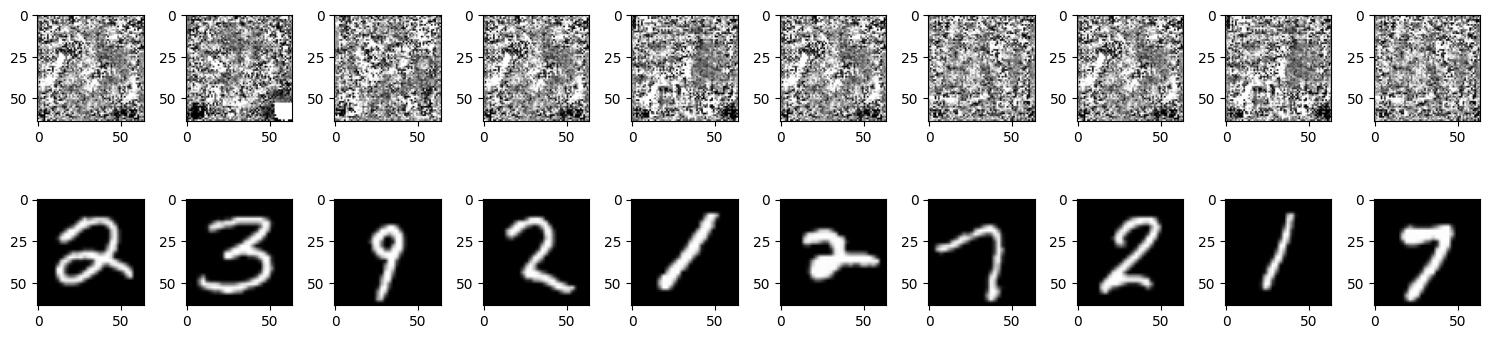

KeyboardInterrupt: ignored

In [173]:
train(gen_cond, disc_cond, train_loader=dl_train, num_epochs=100)

## Task - draw example samples from the trained models
* for each digit class, sample an image
* for each image sample, add the title with the digit which served as a conditioning vector


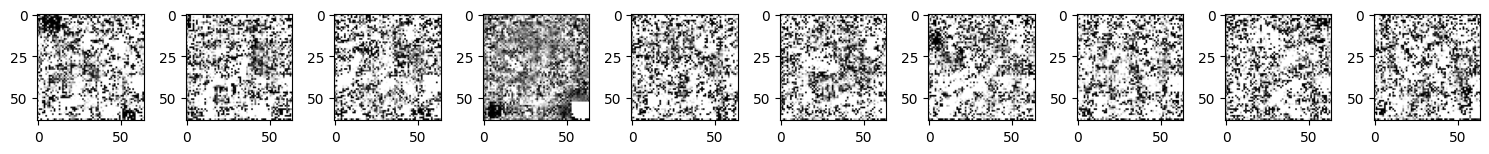

In [172]:

noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
num_row = 1
num_col = 10

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for label in range(10):
  label = torch.tensor(label)
  lista = []
  for i in range(batch_size):
    lista.append(int(label))
  labels = torch.tensor(lista).to(device)
  with torch.no_grad():
    fake = gen_cond(noise, labels)

    ax = axes[label]
    ax.imshow(fake[0].detach().cpu().numpy().reshape(64,64), cmap='gray')

plt.tight_layout()
plt.show()


## Task - draw a couple of examples of interpolation between classes:
For a fixed noise vector, choose two classes and draw samples generated from this noise vector and one-hot vectors of two classes gradually transitioning between the two classes. 

Please print or otherwise indicate which two classes you are transitioining between.

In [ ]:
noise = torch.randn(batch_size, noise_dim, 1, 1)
print(gen(noise, 1))
print(gen(noise, 1.5))